In [1]:
import numpy as np
from matplotlib import pyplot
from scipy import signal
from PySDM.physics import si
from PySDM.initialisation import equilibrate_wet_radii
from PySDM.initialisation.spectra import Lognormal
from PySDM.initialisation.sampling.spectral_sampling import ConstantMultiplicity
from PySDM.backends import CPU
from PySDM.dynamics import AmbientThermodynamics, Condensation
from PySDM.environments import Parcel
from PySDM import Builder, products as PySDM_products
from PySDM.backends.impl_numba.test_helpers import bdf

from atmos_cloud_sim_uj_utils import show_plot
from PySDM_examples.Abdul_Razzak_Ghan_2000.aerosol import AerosolFigure1, AerosolFigure2

In [11]:
class Magick:
    def register(self, builder):
        builder.request_attribute("critical supersaturation")

    def __call__(self):
        pass

def run_parcel(w, N2, n_sd_per_mode):
    rtol_thd = 1e-9
    rtol_x = 1e-9
    scheme = "BDF"

    products = (
     PySDM_products.WaterMixingRatio(unit="g/kg", name="ql"),
     PySDM_products.PeakSupersaturation(name="S max"),
     PySDM_products.AmbientRelativeHumidity(name="RH"),
     PySDM_products.ParcelDisplacement(name="z")
    )
    env = Parcel(
     dt=2 * si.s,
     mass_of_dry_air=1e3 * si.kg,
     p0=1000 * si.hPa,
     q0=22.76 * si.g / si.kg,
     w=w * si.m / si.s,
     T0=300 * si.K
    )
    aerosol = AerosolFigure2(N2)
    n_steps = 50
    n_sd = n_sd_per_mode * len(aerosol.aerosol_modes)

    builder = Builder(backend=CPU(), n_sd=n_sd)
    builder.set_environment(env)
    builder.add_dynamic(AmbientThermodynamics())
    builder.add_dynamic(Condensation(
     adaptive=True,
     rtol_x=rtol_x,
     rtol_thd=rtol_thd,
    ))
    builder.add_dynamic(Magick())

    attributes = {k: np.empty(0) for k in ('dry volume', 'kappa times dry volume', 'n')}
    for i, mode in enumerate(aerosol.aerosol_modes):
        kappa, spectrum = mode["kappa"], mode["spectrum"]
        r_dry, concentration = ConstantMultiplicity(spectrum).sample(n_sd_per_mode)
        v_dry = builder.formulae.trivia.volume(radius=r_dry)
        specific_concentration = concentration / builder.formulae.constants.rho_STP
        attributes['n'] = np.append(attributes['n'], specific_concentration * env.mass_of_dry_air)
        attributes['dry volume'] = np.append(attributes['dry volume'], v_dry)
        attributes['kappa times dry volume'] = np.append(attributes['kappa times dry volume'], v_dry * kappa)
    
    r_wet = equilibrate_wet_radii(
        r_dry=builder.formulae.trivia.radius(volume=attributes['dry volume']),
        environment=env,
        kappa_times_dry_volume=attributes['kappa times dry volume'],
    )
    attributes['volume'] = builder.formulae.trivia.volume(radius=r_wet)

    particulator = builder.build(attributes, products=products)

    if scheme == 'BDF':
        bdf.patch_particulator(particulator)

    output = {product.name: [] for product in particulator.products.values()}
    output_attributes = {'n': tuple([] for _ in range(particulator.n_sd)),
                        'volume': tuple([] for _ in range(particulator.n_sd)),
                        'critical volume': tuple([] for _ in range(particulator.n_sd)),
                        'critical supersaturation': tuple([] for _ in range(particulator.n_sd))}

    for _ in range(n_steps):
        particulator.run(steps=1)
        for product in particulator.products.values():
            value = product.get()
            output[product.name].append(value[0])
        for key, attr in output_attributes.items():
            attr_data = particulator.attributes[key].to_ndarray()
            for drop_id in range(particulator.n_sd):
                attr[drop_id].append(attr_data[drop_id])
    
    error = np.zeros(len(aerosol.aerosol_modes))
    activated_fraction_S = np.zeros(len(aerosol.aerosol_modes))
    activated_fraction_V = np.zeros(len(aerosol.aerosol_modes))
    for j, mode in enumerate(aerosol.aerosol_modes):
        activated_drops_j_S = 0
        activated_drops_j_V = 0
        RHmax = np.nanmax(np.asarray(output['RH']))
        for i, volume in enumerate(output_attributes['volume']):
            if j*n_sd_per_mode <= i < (j+1)*n_sd_per_mode:
                if output_attributes['critical supersaturation'][i][-1] < RHmax:
                    activated_drops_j_S += output_attributes['n'][i][-1]
                if output_attributes['critical volume'][i][-1] < volume[-1]:
                    activated_drops_j_V += output_attributes['n'][i][-1]
        Nj = np.asarray(output_attributes['n'])[j*n_sd_per_mode:(j+1)*n_sd_per_mode, -1]
        max_multiplicity_j = np.max(Nj)
        sum_multiplicity_j = np.sum(Nj)
        error[j] = max_multiplicity_j / sum_multiplicity_j
        activated_fraction_S[j] = activated_drops_j_S / sum_multiplicity_j
        activated_fraction_V[j] = activated_drops_j_V / sum_multiplicity_j
    
    return output, output_attributes, aerosol, activated_fraction_S, activated_fraction_V, error

In [12]:
N2 = np.linspace(100,5000,5)
AF_S = np.zeros((2,len(N2)))
AF_V = np.zeros((2,len(N2)))
AFerror = np.zeros(len(N2))

w = 0.5
n_sd_per_mode = 50

for i,N2i in enumerate(N2):
    output, output_attributes, aerosol, activated_fraction_S, activated_fraction_V, error = run_parcel(w, N2i, n_sd_per_mode)
    AF_S[:,i] = activated_fraction_S
    AF_V[:,i] = activated_fraction_V
    AFerror[i] = error[0]

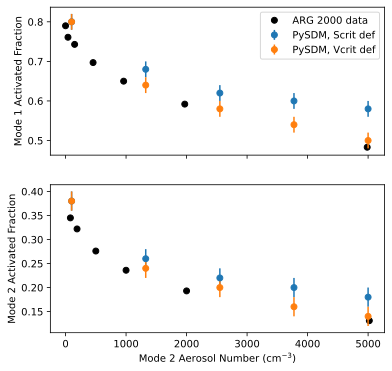

HTML(value="<a href='./fig_2.pdf' target='_blank'>./fig_2.pdf</a><br>")

In [16]:
a_N2_obs = [0, 40, 150, 455, 960, 1970, 4985]
a_ActFrac_obs = [0.790, 0.761, 0.743, 0.697, 0.650, 0.592, 0.483]

b_N2_obs = [80, 190, 500, 1000, 2000, 5020]
b_ActFrac_obs = [0.345, 0.322, 0.276, 0.236, 0.193, 0.131]

fig, axes = pyplot.subplots(2, 1, sharex=True, figsize=(6,6))
axes[0].plot(a_N2_obs, a_ActFrac_obs, "ko", label="ARG 2000 data")
axes[1].plot(b_N2_obs, b_ActFrac_obs, "ko")

for i, ax in enumerate(axes):
    ax.errorbar(N2, AF_S[i,:], yerr=AFerror, fmt='o', label="PySDM, Scrit def")
    ax.errorbar(N2, AF_V[i,:], yerr=AFerror, fmt='o', label="PySDM, Vcrit def")
    ax.set_ylabel(f'Mode {i+1} Activated Fraction')

pyplot.xlabel('Mode 2 Aerosol Number (cm$^{-3}$)')
axes[0].legend(loc="best")
show_plot("fig_2.pdf")

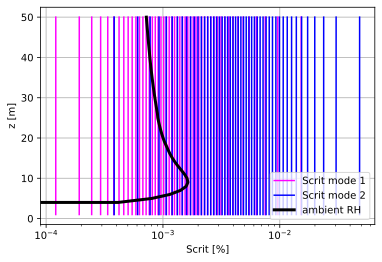

HTML(value="<a href='./RH_profile.pdf' target='_blank'>./RH_profile.pdf</a><br>")

In [20]:
for drop_id, Scrit in enumerate(output_attributes['critical supersaturation']):
    if drop_id < n_sd_per_mode:
        pyplot.plot(
            np.asarray(Scrit) - 1,
            output['z'],
            color='magenta',
            label="Scrit mode 1" if drop_id == 0 else ""
        )
    else:
        pyplot.plot(
            np.asarray(Scrit) - 1,
            output['z'],
            color='blue',
            label="Scrit mode 2" if drop_id == n_sd_per_mode else ""
        )
    pyplot.xlabel('Scrit [%]')
    pyplot.ylabel('z [m]')

pyplot.plot(np.asarray(output['RH'])-1, output['z'], 'k', lw=3, label='ambient RH')
pyplot.xscale('log')
#pyplot.xlim(1e-4,5e-2)
pyplot.legend(loc='lower right')
pyplot.grid()
show_plot("RH_profile.pdf")